In [1]:
from hack_itau_quant import EfficientFrontier
import pandas as pd
import numpy as np
import yfinance as yf

In [2]:
tickers = ['BPAC11.SA', 'ITUB4.SA', 'OIBR3.SA', 'PETR4.SA']

close_prices = yf.download(tickers, start='2017-01-01', end='2021-01-01')['Close']

returns = close_prices.pct_change()[1:]

expected_returns = returns.mean()
cov_matrix = returns.cov()

[*********************100%***********************]  4 of 4 completed


In [3]:
def get_weights(returns, target_return):
    
    expected_returns = returns.mean()
    cov_matrix = returns.cov()
    
    ef = EfficientFrontier(expected_returns, cov_matrix)
    weights = ef.efficient_return(target_return)
    
    return weights

In [4]:
get_weights(returns, target_return=0.001)

array([[0.2046185 ],
       [0.63239379],
       [0.11655584],
       [0.04643187]])

In [5]:
def markowitz_daily_return(wallet_returns, date_index, freq = 20,initial_value = 1):
    
    weights = get_weights(wallet_returns, 0.001)
    
    initial_values = np.multiply(initial_value , weights)
    
    cumulative_returns = wallet_returns.copy()
    
    for value, stock in zip(initial_values, range(len(wallet_returns.columns))):
        cumulative_returns.iloc[:, stock] = value * (1 + wallet_returns.iloc[date_index -freq: date_index, stock]).cumprod()
        
    returns = np.sum(cumulative_returns.iloc[date_index - freq: date_index], axis=1)
    
    return list(returns)

In [6]:
markowitz_daily_return(returns, date_index=20)

[0.8252653986347297,
 0.8267700309858536,
 0.8388223571320239,
 0.8412420693207854,
 0.8473766889059278,
 0.8508865064719981,
 0.8470373681001244,
 0.870700087204391,
 0.8611558828830216,
 0.8712148784135598,
 0.8879653178222366,
 0.8775442217045077,
 0.8715012604664726,
 0.8782779221073678,
 0.9014447010206853,
 0.8994641310709148,
 0.9193603525265442,
 0.9304706137751627,
 0.908308113539348,
 0.9110856769284051]

In [7]:
def to_numpy_array(lists):

    final_list = []

    for l in lists:
        for item in l:
              final_list.append(item)

    return np.array(final_list)

In [8]:
def backtesting(returns, rebalance_frequency, initial_value, investment_on_rebalance = 0):
    cumulative_daily = list()
    
    for t in range(rebalance_frequency + 2, returns.shape[0], rebalance_frequency):
        
        cumulative_daily.append(
            markowitz_daily_return(returns, t, initial_value = initial_value, freq = rebalance_frequency)
        )
        
        initial_value = cumulative_daily[-1][-1] + investment_on_rebalance
    
    prices_left = returns.shape[0] % rebalance_frequency
    
    t = returns.shape[0] - prices_left
    
    has_prices_left = prices_left <= rebalance_frequency
    if has_prices_left:
        cumulative_daily.append(
            markowitz_daily_return(returns, t, initial_value = initial_value, freq = prices_left)
        )
        
    rts = to_numpy_array(cumulative_daily)
    df = pd.DataFrame(rts)
    df.index = returns.index
    df.columns = ['Patrimônio']
    
    df.plot()

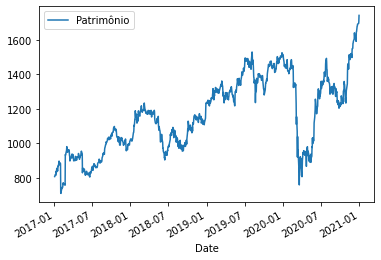

In [9]:
backtesting(returns, 20, 1000)

In [26]:
class Backtesting:
    
    def __init__(self, returns, rebalance_frequency, initial_investment, investment_on_rebalance):
        
        self._returns = returns
        self._n_assets = returns.shape[1]
        self._n_periods = returns.shape[0]
        
        self._rebalance_frequency = rebalance_frequency
        self._initial_investment = initial_investment
        self._investment_on_rebalance = investment_on_rebalance
        
    def run(self):
        cumulative_daily = list()
        
        initial_value = self._initial_investment

        for t in range(self._rebalance_frequency + 2, self._n_periods, self._rebalance_frequency):

            cumulative_daily.append(
                self._get_daily_returns(date_index = t, initial_value = initial_value, freq = self._rebalance_frequency)
            )

            initial_value = cumulative_daily[-1][-1] + self._investment_on_rebalance

        prices_left = self._n_periods % self._rebalance_frequency
        has_prices_left = prices_left <= self._rebalance_frequency
        if has_prices_left:
                
            t = self._n_periods - prices_left
            
            cumulative_daily.append(
                self._get_daily_returns(t, initial_value = initial_value, freq = prices_left)
            )

        rts = to_numpy_array(cumulative_daily)
        df = pd.DataFrame(rts)
        df.index = returns.index
        df.columns = ['Patrimônio']

        return df

    def _get_daily_returns(self, date_index, initial_value, freq):
        
        weights = Backtesting.get_markowitz_weights(self._returns.iloc[:date_index, :])

        initial_values = np.multiply(initial_value , weights)

        cumulative_returns = self._returns.copy()

        for value, stock in zip(initial_values, range(len(self._returns.columns))):
            cumulative_returns.iloc[:, stock] = value * (1 + self._returns.iloc[date_index -freq: date_index, stock]).cumprod()

        returns = np.sum(cumulative_returns.iloc[date_index - freq: date_index], axis=1)

        return list(returns)
    
    @staticmethod
    def get_markowitz_weights(returns):
    
        expected_returns = returns.mean()
        cov_matrix = returns.cov()

        ef = EfficientFrontier(expected_returns, cov_matrix)
        weights = ef.min_risk()
        
        return weights
    
    
    @staticmethod
    def get_equal_weights(n_assets):
        
        return np.ones(n_assets) / n_assets

In [27]:
backtesting = Backtesting(returns = returns, rebalance_frequency = 20, initial_investment = 1000, investment_on_rebalance = 0)

In [28]:
backtesting.run()

,Patrimônio
Date,
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,0.0
2017-01-06,0.0
2017-01-09,0.0
...,...
2020-12-22,0.0
2020-12-23,0.0
2020-12-28,0.0


<AxesSubplot:xlabel='Date'>

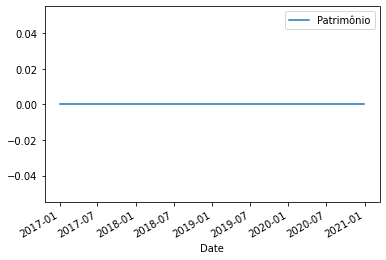

In [19]:
_.plot()

In [14]:
for i in range(30, returns.shape[0]):
    Backtesting.get_markowitz_weights(returns.iloc[:i, :])

/mnt/c/Users/lucas/Desktop/Codes/hack-itau-quant/hack_itau_quant/optimization/markowitz.py:57: RuntimeWarning: invalid value encountered in sqrt
  start_risk = 1 / np.sqrt(self._C)


In [15]:
Backtesting.get_markowitz_weights(returns.iloc[30:, :])

array([[0.09692714],
       [0.76527519],
       [0.11173587],
       [0.0260618 ]])